<a href="https://colab.research.google.com/github/KATTA-00/CO542-Neural-Networks-Labs/blob/main/lab06/E19129_lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CO542 - Neural Networks and Fuzzy Systems
## E/19/129 - K.H. Gunawardana

### Lab 06: Recurrent Neural Networks (RNN)

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Installation and Creating an RNN Model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, hidden = self.rnn(x)
        # Use the last hidden state for classification
        out = self.fc(hidden[-1])
        return out


model = RNN(vocab_size=10000, embed_size=128, hidden_size=256,
num_classes=2)

In [3]:
import tensorflow_datasets as tfds
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import re

In [5]:
# Step 1: Load the IMDB dataset
print("Loading IMDB dataset...")
ds, info = tfds.load('imdb_reviews',
                     split=['train', 'test'],
                     shuffle_files=True,
                     as_supervised=True,
                     with_info=True)

train_ds, test_ds = ds

# Convert to lists for easier processing
train_texts = []
train_labels = []
test_texts = []
test_labels = []

print("Processing training data...")
for text, label in train_ds:
    train_texts.append(text.numpy().decode('utf-8'))
    train_labels.append(label.numpy())

print("Processing test data...")
for text, label in test_ds:
    test_texts.append(text.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"First training example: {train_texts[0][:200]}...")
print(f"First training label: {train_labels[0]}")

Loading IMDB dataset...
Processing training data...
Processing test data...
Training samples: 25000
Test samples: 25000
First training example: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting ...
First training label: 0


In [6]:
# Step 2: Text Preprocessing and Tokenization
def clean_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def tokenize_text(text):
    """Simple tokenization by splitting on whitespace"""
    return text.split()

print("Cleaning and tokenizing texts...")
train_texts_clean = [clean_text(text) for text in train_texts]
test_texts_clean = [clean_text(text) for text in test_texts]

train_tokens = [tokenize_text(text) for text in train_texts_clean]
test_tokens = [tokenize_text(text) for text in test_texts_clean]

print(f"Sample cleaned text: {train_texts_clean[0][:200]}...")
print(f"Sample tokens: {train_tokens[0][:20]}")


Cleaning and tokenizing texts...
Sample cleaned text: this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could...
Sample tokens: ['this', 'was', 'an', 'absolutely', 'terrible', 'movie', 'dont', 'be', 'lured', 'in', 'by', 'christopher', 'walken', 'or', 'michael', 'ironside', 'both', 'are', 'great', 'actors']


In [7]:
# Step 3: Build Vocabulary
def build_vocabulary(token_lists, vocab_size=10000):
    """Build vocabulary from token lists"""
    # Count all words
    word_counts = Counter()
    for tokens in token_lists:
        word_counts.update(tokens)

    # Get most common words
    most_common = word_counts.most_common(vocab_size - 2)  # -2 for PAD and UNK

    # Create word to index mapping
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        word_to_idx[word] = len(word_to_idx)

    # Create index to word mapping
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return word_to_idx, idx_to_word

print("Building vocabulary...")
vocab_size = 10000
word_to_idx, idx_to_word = build_vocabulary(train_tokens, vocab_size)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Sample vocabulary: {list(word_to_idx.items())[:10]}")

Building vocabulary...
Vocabulary size: 10000
Sample vocabulary: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9)]


Converting texts to sequences...
Average training sequence length: 227.75
Max training sequence length: 2441
Average test sequence length: 222.63
Max test sequence length: 2182


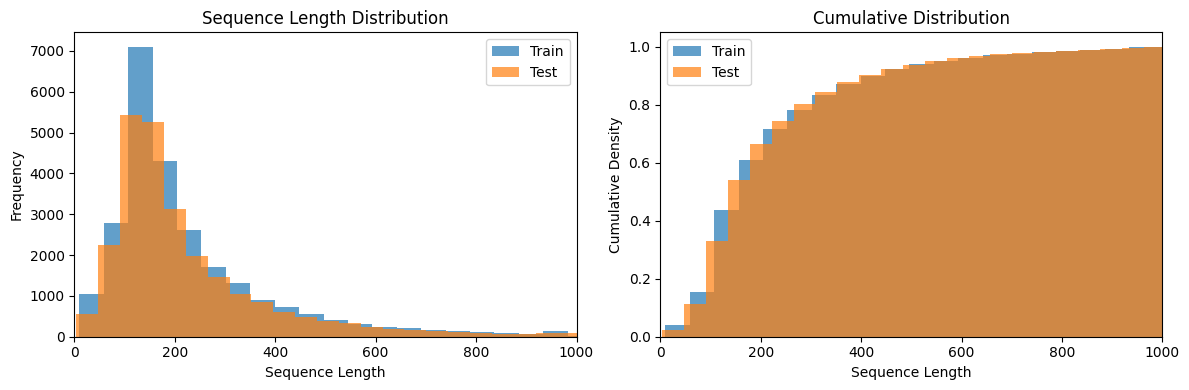

In [8]:
# Step 4: Convert text to numerical sequences
def texts_to_sequences(token_lists, word_to_idx):
    """Convert token lists to numerical sequences"""
    sequences = []
    for tokens in token_lists:
        sequence = []
        for token in tokens:
            if token in word_to_idx:
                sequence.append(word_to_idx[token])
            else:
                sequence.append(word_to_idx['<UNK>'])  # Unknown word
        sequences.append(sequence)
    return sequences

print("Converting texts to sequences...")
train_sequences = texts_to_sequences(train_tokens, word_to_idx)
test_sequences = texts_to_sequences(test_tokens, word_to_idx)

# Check sequence lengths
train_lengths = [len(seq) for seq in train_sequences]
test_lengths = [len(seq) for seq in test_sequences]

print(f"Average training sequence length: {np.mean(train_lengths):.2f}")
print(f"Max training sequence length: {max(train_lengths)}")
print(f"Average test sequence length: {np.mean(test_lengths):.2f}")
print(f"Max test sequence length: {max(test_lengths)}")

# Plot sequence length distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.legend()
plt.xlim(0, 1000)

plt.subplot(1, 2, 2)
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train', cumulative=True, density=True)
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test', cumulative=True, density=True)
plt.xlabel('Sequence Length')
plt.ylabel('Cumulative Density')
plt.title('Cumulative Distribution')
plt.legend()
plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

In [9]:
# Step 5: Pad sequences to uniform length
def pad_sequences(sequences, max_length=None, padding_value=0):
    """Pad sequences to uniform length"""
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    padded_sequences = []
    for seq in sequences:
        if len(seq) >= max_length:
            # Truncate if too long
            padded_seq = seq[:max_length]
        else:
            # Pad if too short
            padded_seq = seq + [padding_value] * (max_length - len(seq))
        padded_sequences.append(padded_seq)

    return padded_sequences

# Choose a reasonable max length (e.g., 95th percentile)
max_length = int(np.percentile(train_lengths + test_lengths, 95))
print(f"Chosen max_length: {max_length}")

print("Padding sequences...")
train_sequences_padded = pad_sequences(train_sequences, max_length)
test_sequences_padded = pad_sequences(test_sequences, max_length)

# Convert to numpy arrays
X_train = np.array(train_sequences_padded)
y_train = np.array(train_labels)
X_test = np.array(test_sequences_padded)
y_test = np.array(test_labels)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Chosen max_length: 575
Padding sequences...
Training data shape: (25000, 575)
Training labels shape: (25000,)
Test data shape: (25000, 575)
Test labels shape: (25000,)


In [10]:
# Step 6: Create PyTorch datasets and dataloaders
# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify data loading
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}: Data shape: {data.shape}, Target shape: {target.shape}")
    print(f"Sample data: {data[0][:10]}")
    print(f"Sample target: {target[0]}")
    break

print("\nData preparation completed successfully!")
print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Sequence length: {max_length}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training batches: 391
Test batches: 391
Batch 0: Data shape: torch.Size([64, 575]), Target shape: torch.Size([64])
Sample data: tensor([ 234,    2,  110, 6228,   13,   28,    5,   58,  494,  898])
Sample target: 0

Data preparation completed successfully!
Vocabulary size: 10000
Sequence length: 575
Training samples: 25000
Test samples: 25000
